# Kay (2012) Figure 7, Panel 4

## MISR low-topped thick cloud, MODIS high-topped thick cloud

### Function and package imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    mpl
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Interpolation functions with xESMF

In [2]:
from interp_functions import *

#### Taylor plot specific imports

In [3]:
import taylor_jshaw as taylor
import matplotlib as matplotlib
import matplotlib.patches as patches

#### Stats specific imports

In [4]:
import scipy.stats as stats

In [5]:
def get_min_max(da):
    '''
    Requires the file to have identifiable limits/null values.
    '''
    if ('valid_min' in da.attrs and 'valid_max' in da.attrs):
        _min = da.valid_min
        _min_flt = np.float(_min.split(' ')[-1])

        _max = da.valid_max
        _max_flt = np.float(_max.split(' ')[-1])
        
        return _min_flt,_max_flt
        
    elif 'valid_range' in da.attrs:       
        _min_flt = da.valid_range[0]
        _max_flt = da.valid_range[1]
    
        return _min_flt,_max_flt

In [6]:
def get_mask(da):
    '''
    Return values to mask (i.e. to use with where() after inverting).
    Requires the file to have identifiable limits/null values.
    '''
    
    _min,_max = get_min_max(da)

    # these values are True if they should be discarded, should catch Nans
    mask = np.invert(np.bitwise_and(da < _max, da > _min,))
    
    return mask

#### Path for pre-processed files:

In [7]:
obs_dir_temp = '/glade/work/jonahshaw/obs/preprocessed/'

### Get MISR total cloud observations on their native grid (just for mask making)

In [8]:
misr_obs_dir = '/glade/u/home/jonahshaw/w/obs/MISR/cfmip_orig/'
misr_files = ['%s/%s' % (misr_obs_dir,i) for i in os.listdir(misr_obs_dir)]

In [9]:
clt_misr_file = '%s/%s' % ('/glade/u/home/jonahshaw/w/obs/MISR/','clt_MISR_20000301_20200531.nc')
if os.path.exists(clt_misr_file):
    clt_misr = xr.open_dataset(clt_misr_file)
else:
    all_misr = xr.open_mfdataset(misr_files)
    # take bins with tau > 0.3 (discard first two) and not cth = -1 (?? read documentation)
    clt_misr0 = all_misr.isel(tau=np.arange(2,8),cth=np.arange(1,16)) # change 1 to 0  
#     clt_misr0 = all_misr.isel(tau=slice(2,-1),cth=slice(1,-1)) 
    clt_misr = clt_misr0.sum(['tau','cth']) # sum over the selected histogram bins  
    clt_misr.to_netcdf(clt_misr_file)

### Get MISR low-topped thick cloud observations on their native grid

In [10]:
cldthick_misr_file = '%s/%s' % ('/glade/u/home/jonahshaw/w/obs/MISR/','cldthick_MISR_20000301_20200531.nc')
if os.path.exists(cldthick_misr_file):
    cldthick_misr = xr.open_dataset(cldthick_misr_file)
else:
    all_misr = xr.open_mfdataset(misr_files)
    # tau >23, cth < 3km gross index selecting
    thick_misr0 = all_misr.isel(tau=np.arange(6,8),cth=np.arange(1,7)) # change 1 to 0
    cldthick_misr = thick_misr0.sum(['tau','cth'])
    cldthick_misr.to_netcdf(cldthick_misr_file)

### Create mask for MISR

Use a monthly average mask instead of a monthly total mask? Better?

In [11]:
clt_misr_monthly = clt_misr['clMISR'].groupby('time.month').mean('time')
cldthick_misr_monthly = cldthick_misr['clMISR'].groupby('time.month').mean('time')

Mask using total cloud fraction

In [12]:
misr_mask_monthly = clt_misr_monthly > 0
misr_mask_months = clt_misr > 0 # mask each month individually so as not to average over sea ice changes

In [13]:
# masks cells that are zero for every february in the observations (ex.)
clt_misr_mean2 = clt_misr_monthly.where(misr_mask_monthly).mean('month')
cldthick_misr_mean2 = cldthick_misr_monthly.where(misr_mask_monthly).mean('month')

# masks cells that are zero for each february
clt_misr_mean3 = clt_misr['clMISR'].where(misr_mask_months).mean('time')
cldthick_misr_mean3 = cldthick_misr['clMISR'].where(misr_mask_months).mean('time')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### These are different because of how I selected the histograms.

In [14]:
temp = add_weights(clt_misr_mean2)

avg = masked_average(clt_misr_mean2,weights=temp['cell_weight'])
print(avg.values)

60.173255360518645


In [15]:
temp = add_weights(clt_misr_mean3)

avg = masked_average(clt_misr_mean3,weights=temp['cell_weight'])
print(avg.values)

<bound method Mapping.values of <xarray.Dataset>
Dimensions:      ()
Data variables:
    clMISR       float64 63.08
    cth_bnds     float64 39.05
    lat_bnds     float64 31.38
    lon_bnds     float64 34.39
    samplesMISR  float64 63.07
    tau_bnds     float64 39.05
    cell_weight  float64 0.006854>


In [16]:
temp = add_weights(cldthick_misr_mean2)

avg = masked_average(cldthick_misr_mean2,weights=temp['cell_weight'])
print(avg.values)

2.2951230529678632


In [17]:
temp = add_weights(cldthick_misr_mean3)

avg = masked_average(cldthick_misr_mean3,weights=temp['cell_weight'])
print(avg.values)

<bound method Mapping.values of <xarray.Dataset>
Dimensions:      ()
Data variables:
    clMISR       float64 2.435
    cth_bnds     float64 1.451
    lat_bnds     float64 1.009
    lon_bnds     float64 1.231
    samplesMISR  float64 2.434
    tau_bnds     float64 1.451
    cell_weight  float64 0.006854>


In [18]:
all_misr = xr.open_mfdataset(misr_files)
# tau >23, cth < 3km gross index selecting
thick_misr_alt0 = all_misr.isel(tau=np.arange(6,8),cth=np.arange(0,7)) # change 1 to 0
cldthick_misr_alt = thick_misr_alt0.sum(['tau','cth'])
# cldthick_misr.to_netcdf(cldthick_misr_file)

#### The low-topped thick MISR cloud increases by ~0.5% when I add the -1 height histogram box.

In [19]:
clt_misr_alt_mean = cldthick_misr_alt['clMISR'].where(misr_mask_months).mean('time')

temp = add_weights(clt_misr_alt_mean)

avg = masked_average(clt_misr_alt_mean['clMISR'],weights=temp['cell_weight'])
print(avg.values)

2.9489918310211007


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### MODIS observations

In [20]:
modis_obs_dir = '/glade/u/home/jonahshaw/obs/COSP/MODIS/'
modis_file = 'MCD03_M3_NC_200207to201007.V01.nc'

In [21]:
cld_modis_obs = xr.open_dataset('%s/%s' % (modis_obs_dir,modis_file))

In [22]:
cld_modis_obs

<xarray.Dataset>
Dimensions:                                                  (Cloud_Optical_Thickness: 7, Cloud_Top_Pressure: 7, lat: 180, lon: 360, nbnds: 2)
Coordinates:
  * lat                                                      (lat) float32 89...
  * lon                                                      (lon) float32 -1...
  * Cloud_Optical_Thickness                                  (Cloud_Optical_Thickness) float32 ...
  * Cloud_Top_Pressure                                       (Cloud_Top_Pressure) float32 ...
Dimensions without coordinates: nbnds
Data variables:
    Cloud_Optical_Thickness_bnds                             (nbnds, Cloud_Optical_Thickness) float32 ...
    Cloud_Top_Pressure_bnds                                  (nbnds, Cloud_Top_Pressure) float32 ...
    Cloud_Top_Pressure_Total_Mean                            (lat, lon) float32 ...
    Cloud_Fraction_Mask_Total_Mean                           (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Mean                      (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Uncertainty_in_Mean       (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Uncertainty_in_MeanLog10  (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_MeanLog10                 (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Mean                         (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Uncertainty_in_Mean          (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Uncertainty_in_MeanLog10     (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_MeanLog10                    (lat, lon) float32 ...
    Cloud_Optical_Thickness_Total_Mean                       (lat, lon) float32 ...
    Cloud_Optical_Thickness_Total_MeanLog10                  (lat, lon) float32 ...
    Optical_Thickness_vs_Cloud_Top_Pressure                  (lat, lon, Cloud_Top_Pressure, Cloud_Optical_Thickness) float32 ...
    Cloud_Particle_Size_Liquid_Mean                          (lat, lon) float32 ...
    Cloud_Particle_Size_Liquid_Uncertainty_in_Mean           (lat, lon) float32 ...
    Cloud_Particle_Size_Ice_Mean                             (lat, lon) float32 ...
    Cloud_Particle_Size_Ice_Uncertainty_in_Mean              (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Liquid_Mean                     (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Ice_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Total_Mean                      (lat, lon) float32 ...
    Liquid_Path_Mean                                         (lat, lon) float32 ...
    Liquid_Path_Uncertainty_in_Mean                          (lat, lon) float32 ...
    Ice_Path_Mean                                            (lat, lon) float32 ...
    Ice_Path_Uncertainty_in_Mean                             (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_High_Mean                       (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Mid_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Low_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Mask_High_Mean                            (lat, lon) float32 ...
    Cloud_Fraction_Mask_Mid_Mean                             (lat, lon) float32 ...
    Cloud_Fraction_Mask_Low_Mean                             (lat, lon) float32 ...
Attributes:
    Retrieval_Version:         Collection 51
    Begin_Date:                2002-07-01
    Conventions:               CF-1.4
    Title:                     MODIS cloud observations for climate model eva...
    history:                   Wed Apr  6 15:17:35 2011: ncea -O MCD03_M3_NC....
    nco_openmp_thread_number:  1

In [23]:
cld_modis_obs['Optical_Thickness_vs_Cloud_Top_Pressure']

<xarray.DataArray 'Optical_Thickness_vs_Cloud_Top_Pressure' (lat: 180, lon: 360, Cloud_Top_Pressure: 7, Cloud_Optical_Thickness: 7)>
[3175200 values with dtype=float32]
Coordinates:
  * lat                      (lat) float32 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * lon                      (lon) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
  * Cloud_Optical_Thickness  (Cloud_Optical_Thickness) float32 0.15 ... 80.0
  * Cloud_Top_Pressure       (Cloud_Top_Pressure) float32 9000.0 ... 95000.0
Attributes:
    long_name:          Joint histogram of optical thickness and cloud top pr...
    HDF_variable_name:  Cloud_Optical_Thickness_ISCCP_Joint_Histogram_vs_Pres...
    valid_range:        [     0. 465000.]
    units:              1

#### Select modis histogram bins with tau > 23 and ctp < 440mb (44000Pa)

In [25]:
cld_thick_modis0 = cld_modis_obs['Optical_Thickness_vs_Cloud_Top_Pressure'].sel(Cloud_Optical_Thickness=slice(22.9,6e4),Cloud_Top_Pressure=slice(0,44000))

In [83]:
cld_thick_modis = cld_thick_modis0.sum(['Cloud_Optical_Thickness','Cloud_Top_Pressure'])*100

#### Roughly 0.05 on the global average, looks good!

In [31]:
temp = add_weights(cld_thick_modis)

avg = masked_average(cld_thick_modis,weights=temp['cell_weight'])
print(avg.values)

0.04737377


## Extract observations

## Done with observation processing, now model processing.

### Grab post-processed CAM4 and CAM5 data

In [32]:
post_proc_path = '/glade/u/home/jonahshaw/s/archive/Kay_COSP_2012/'

In [33]:
cam4_proc_dir = '%s/%s/atm/proc/tseries/month_1/' % (post_proc_path,'cam4_1deg_release_amip')
cam5_proc_dir = '%s/%s/atm/proc/tseries/month_1/' % (post_proc_path,'cam5_1deg_release_amip')

### MISR

In [34]:
cam4_misr_file = [i for i in os.listdir(cam4_proc_dir) if "CLD_MISR" in i]
cam5_misr_file = [i for i in os.listdir(cam5_proc_dir) if "CLD_MISR" in i]

In [35]:
cam4_misr = xr.open_dataset('%s/%s' % (cam4_proc_dir,cam4_misr_file[0]))
cam5_misr = xr.open_dataset('%s/%s' % (cam5_proc_dir,cam5_misr_file[0]))

In [36]:
cam4_misr['time'] = cam4_misr['time_bnds'].isel(nbnd=0)
cam5_misr['time'] = cam5_misr['time_bnds'].isel(nbnd=0)

In [38]:
cam4_misr_cldthick_file = '%s/%s' % (cam4_proc_dir,'cam4_1deg_release_amip.cam.h0.CLDTHICK_MISR.200101-201012.nc')
if os.path.exists(cam4_misr_cldthick_file):
    cam4_thick_misr = xr.open_dataset(cam4_misr_cldthick_file)
else:
    # tau >23, cth < 3km gross index selecting
    cam4_thick_misr0 = cam4_misr['CLD_MISR'].sel(cosp_htmisr=slice(0,3),cosp_tau=slice(22.9,6e4))
    cam4_thick_misr = cam4_thick_misr0.sum(['cosp_htmisr','cosp_tau'])
    cam4_thick_misr.to_netcdf(cam4_misr_cldthick_file)

In [39]:
cam5_misr_cldthick_file = '%s/%s' % (cam5_proc_dir,'cam5_1deg_release_amip.cam.h0.CLDTHICK_MISR.200101-201012.nc')
if os.path.exists(cam5_misr_cldthick_file):
    cam5_thick_misr = xr.open_dataset(cam5_misr_cldthick_file)
else:
    # tau >23, cth < 3km gross index selecting
    cam5_thick_misr0 = cam5_misr['CLD_MISR'].sel(cosp_htmisr=slice(0,3),cosp_tau=slice(22.9,6e4))
    cam5_thick_misr = cam5_thick_misr0.sum(['cosp_htmisr','cosp_tau'])
    cam5_thick_misr.to_netcdf(cam5_misr_cldthick_file)

In [40]:
cam4_thick_misr = cam4_thick_misr.sel(time=slice('2001-01-01','2010-12-31')).groupby('time.month').mean('time')
cam5_thick_misr = cam5_thick_misr.sel(time=slice('2001-01-01','2010-12-31')).groupby('time.month').mean('time')

In [42]:
cam4_thick_misr_interp,rgrdr = interp_like2D(cam4_thick_misr,target=misr_mask_monthly)

cam5_thick_misr_interp,_ = interp_like2D(cam5_thick_misr,regridder=rgrdr)

#### Apply monthly mask and time average

In [45]:
cam4_thick_misr_f = cam4_thick_misr_interp.where(misr_mask_monthly).mean('month')
cam5_thick_misr_f = cam5_thick_misr_interp.where(misr_mask_monthly).mean('month')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### MODIS

In [48]:
cam4_modis_file = [i for i in os.listdir(cam4_proc_dir) if "CLMODIS" in i]
cam5_modis_file = [i for i in os.listdir(cam5_proc_dir) if "CLMODIS" in i]

In [61]:
cam4_modis = xr.open_dataset('%s/%s' % (cam4_proc_dir,cam4_modis_file[0]))
cam5_modis = xr.open_dataset('%s/%s' % (cam5_proc_dir,cam5_modis_file[0]))

In [62]:
cam4_modis['time'] = cam4_modis['time_bnds'].isel(nbnd=0)
cam5_modis['time'] = cam5_modis['time_bnds'].isel(nbnd=0)

In [63]:
cam4_modis_cldthick_file = '%s/%s' % (cam4_proc_dir,'cam4_1deg_release_amip.cam.h0.CLDTHICK_MODIS.200101-201012.nc')
if os.path.exists(cam4_modis_cldthick_file):
    cam4_thick_modis = xr.open_dataset(cam4_modis_cldthick_file)
else:
    # tau >23, cth < 440mb gross index selecting
    cam4_thick_modis0 = cam4_modis['CLMODIS'].sel(cosp_prs=slice(440,0),cosp_tau_modis=slice(22.9,6e4)) # CTP <440mb,tau>23
    cam4_thick_modis = cam4_thick_modis0.sum(['cosp_prs','cosp_tau_modis'])
    cam4_thick_modis.to_netcdf(cam4_modis_cldthick_file)

In [64]:
cam5_modis_cldthick_file = '%s/%s' % (cam5_proc_dir,'cam5_1deg_release_amip.cam.h0.CLDTHICK_MODIS.200101-201012.nc')
if os.path.exists(cam5_modis_cldthick_file):
    cam5_thick_modis = xr.open_dataset(cam5_modis_cldthick_file)
else:
    # tau >23, ctp < 440mb gross index selecting
    cam5_thick_modis0 = cam5_modis['CLMODIS'].sel(cosp_prs=slice(440,0),cosp_tau_modis=slice(22.9,6e4)) # CTP <440mb,tau>23
    cam5_thick_modis = cam5_thick_modis0.sum(['cosp_prs','cosp_tau_modis'])
    cam5_thick_modis.to_netcdf(cam5_modis_cldthick_file)

In [65]:
cam4_thick_modis = cam4_thick_modis.sel(time=slice('2001-01-01','2010-12-31')).mean('time')
cam5_thick_modis = cam5_thick_modis.sel(time=slice('2001-01-01','2010-12-31')).mean('time')

In [66]:
cam4_thick_modis_interp,rgrdr = interp_like2D(cam4_thick_modis,target=cld_thick_modis)

cam5_thick_modis_interp,_ = interp_like2D(cam5_thick_modis,regridder=rgrdr)

### Define function for calculating relevant values

In [84]:
def calculate(cntl,test):
    """Calculate Taylor statistics for making taylor diagrams."""
    
    _cntl = add_weights(cntl)
    wgt = np.array(_cntl['cell_weight'])
    
    # calculate sums and means
    sumwgt = np.sum(wgt)
    meantest = np.sum(wgt*test)/sumwgt
    meancntl = np.sum(wgt*cntl)/sumwgt

    # calculate variances
    stdtest = (np.sum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
    stdcntl = (np.sum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

    # calculate correlation coefficient
    ccnum = np.sum(wgt*(test-meantest)*(cntl-meancntl))
    ccdem = sumwgt*stdtest*stdcntl
    corr = ccnum/ccdem

    # calculate variance ratio
    ratio = stdtest/stdcntl

    # calculate bias
    bias = (meantest - meancntl)/np.abs(meancntl)
    #self.bias = meantest - meancntl

    # calculate centered pattern RMS difference
    try:
        rmssum = np.sum(wgt*((test-meantest)-(cntl-meancntl))**2.0)
        
    except:
        print(((test-meantest)-(cntl-meancntl)).shape)
        print(((test-meantest)-(cntl-meancntl)).lat)
        print(((test-meantest)-(cntl-meancntl)).lon)
    rmserr = (rmssum/sumwgt)**0.5
    rmsnorm = rmserr/stdcntl
    
#     return corr,ratio,bias,rmsnorm
    return bias,corr,rmsnorm,ratio

### Calculate Taylor-relevant values

In [85]:
cld_thick_modis.mean()

<xarray.DataArray 'Optical_Thickness_vs_Cloud_Top_Pressure' ()>
array(4.449162, dtype=float32)

#### Set-up

In [86]:
# Control names dictionary (i.e. observations)
cntlnames = {
#         'CLDTOT_ISCCP': isccp_obs_fin,
        'CLD_MISR': cldthick_misr_mean2,
        'CLMODIS': cld_thick_modis,
#         'CLDTOT_CAL': caliop_clt_mean,
    }

# Case names
testnames = ('CAM4','CAM5')
testmetrics = {'CLD_MISR':[cam4_thick_misr_f,cam5_thick_misr_f],
               'CLMODIS':[cam4_thick_modis_interp,cam5_thick_modis_interp],}
#                'CLD_MISR':[cam4_misr_interp,cam5_misr_interp],
#                'CLDTOT_CAL':[cam4_caliop_interp,cam5_caliop_interp]}
testcolors = ('SkyBlue','Firebrick')

### Calculate

In [87]:
varnames = ['CLD_MISR','CLMODIS']
# varnames = ['CLDTOT_ISCCP','CLD_MISR','CLDTOT_CAL']

nvars = 2; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric[var]
        
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
        
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

In [88]:
# Fix fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

### Plot

#### The MISR values appear to be wrong.

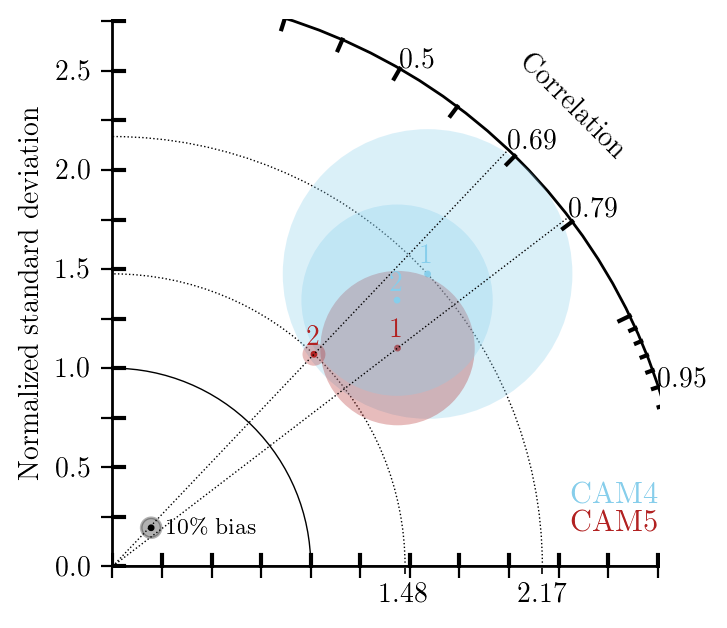

In [89]:
figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )